# Training a LSTM

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [77]:
def clean_df(df):
    """
    Convertit toutes les colonnes contenant des valeurs en dollars (avec $) en float.

    Paramètres:
    df (pd.DataFrame): DataFrame contenant les colonnes à convertir.

    Retourne:
    pd.DataFrame: DataFrame avec les colonnes converties en float.
    """
    df_converti = df.copy()
    for colonne in df_converti.columns:
        if colonne == 'Date':
            continue
        # Vérifie si la première valeur de la colonne contient un $
        if df_converti[colonne].dtype == object and df_converti[colonne].str.contains('$', na=False).any():
            # Supprime le symbole $ et convertit en float
            df_converti[colonne] = df_converti[colonne].str.replace('$', '', regex=False).astype(float)
    return df_converti

In [78]:
dataset_path = 'data/HistoricalQuotes.csv'

df = pd.read_csv(dataset_path)
df = df.rename(str.strip, axis='columns')
df = clean_df(df)
df = df.iloc[::-1].reset_index(drop=True)
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,03/01/2010,29.8557,137312041,29.3928,29.9286,29.3500
1,03/02/2010,29.8357,141486282,29.9900,30.1186,29.6771
2,03/03/2010,29.9043,92846488,29.8486,29.9814,29.7057
3,03/04/2010,30.1014,89591907,29.8971,30.1314,29.8043
4,03/05/2010,31.2786,224647427,30.7057,31.3857,30.6614


In [79]:
print('Columns :', df.columns)
df['Open'].head()

Columns : Index(['Date', 'Close/Last', 'Volume', 'Open', 'High', 'Low'], dtype='object')


0    29.3928
1    29.9900
2    29.8486
3    29.8971
4    30.7057
Name: Open, dtype: float64

In [80]:
dataset_size = len(df)
print(dataset_size)

2518


In [81]:
aapl_open = df['Open']
aapl_close = df['Close/Last']
aapl_low = df['Low']
aapl_high = df['High']
aapl_volume = df['Volume']

aapl_growth = aapl_close.pct_change() * 100
aapl_growth = aapl_growth.fillna(0.0)

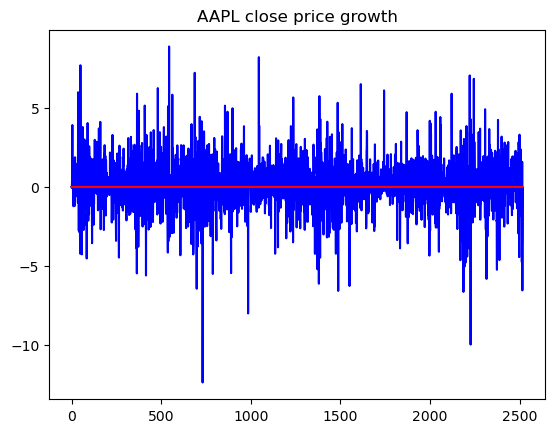

0.1012356922970213


In [82]:
plt.plot(aapl_growth, '-b')
plt.plot([0]*len(aapl_growth), '-r')
plt.title('AAPL close price growth')
plt.show()

df.insert(len(df.columns), "Growth", aapl_growth)
print(np.mean(aapl_growth))

In [83]:
df

,Date,Close/Last,Volume,Open,High,Low,Growth
0,03/01/2010,29.8557,137312041,29.3928,29.9286,29.3500,0.000000
1,03/02/2010,29.8357,141486282,29.9900,30.1186,29.6771,-0.066989
2,03/03/2010,29.9043,92846488,29.8486,29.9814,29.7057,0.229926
3,03/04/2010,30.1014,89591907,29.8971,30.1314,29.8043,0.659103
4,03/05/2010,31.2786,224647427,30.7057,31.3857,30.6614,3.910782
...,...,...,...,...,...,...,...
2513,02/24/2020,298.1800,55548830,297.2600,304.1800,289.2300,-4.750040
2514,02/25/2020,288.0800,57668360,300.9500,302.5300,286.1300,-3.387216
2515,02/26/2020,292.6500,49678430,286.5300,297.8800,286.5000,1.586365
2516,02/27/2020,273.5200,80151380,281.1000,286.0000,272.9600,-6.536819


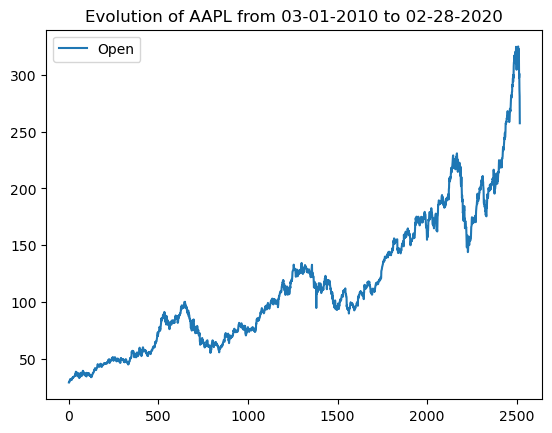

In [84]:
plt.plot(aapl_open, label = 'Open')

plt.legend()
plt.title('Evolution of AAPL from 03-01-2010 to 02-28-2020')
plt.show()

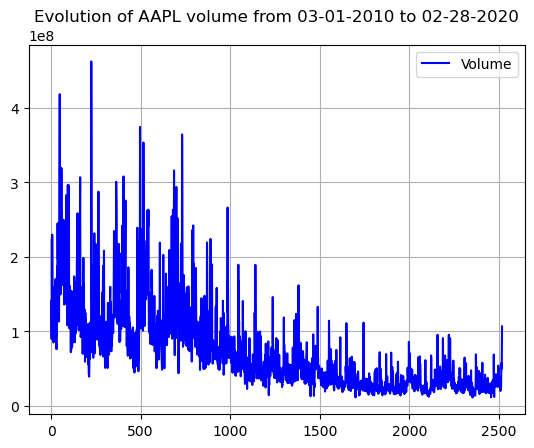

In [85]:
plt.plot(aapl_volume, '-b', label = 'Volume')


plt.legend()
plt.grid()
plt.title('Evolution of AAPL volume from 03-01-2010 to 02-28-2020')
plt.show()

In [86]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_dataset = scaler.fit_transform(df[['Close/Last']])
#scaled_dataset = scaler.fit_transform(df[['Growth']])
print(scaled_dataset.shape)

(2518, 1)


In [87]:
# If we want to access to the original data
# original_data = scaler.inverse_transform(scaled_data)

In [88]:
last_training_index = round(0.85 * dataset_size)
train_datas = scaled_dataset[:last_training_index]
test_datas = scaled_dataset[last_training_index:]

train_size = len(train_datas)
test_size = len(test_datas)

print('train size :', train_size)
print('test size :', test_size)

train size : 2140
test size : 378


In [89]:
class FinanceDataset(Dataset):
    def __init__(self, arr: np.array):
        self.data = arr

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        return torch.tensor(row, dtype=torch.float32).unsqueeze(0)

In [90]:
batch_size = 1

# Every dataset contains scaled data
train_dataset = FinanceDataset(train_datas)
test_dataset = FinanceDataset(test_datas)

In [91]:
# Initialization of the input dimension
for data in train_dataset:
    print(data)
    input_dim = data.shape[1]
    break

hidden_dim = 64

print('input_dim :', input_dim)
print('hidden_dim :', hidden_dim)

tensor([[6.7258e-05]])
input_dim : 1
hidden_dim : 64


## Creating a LSTM

In [92]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size = 64, num_layers = 3):
        super(LSTMNet, self).__init__()
        
        # self.linear0 = torch.nn.Linear(input_size, input_size)

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)

        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, 1)
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

    def forward(self, x, last = None):
        # x.shape = batch_size, sequence_length, embedding size
        # x = self.linear0(x)
        if last is None:
            x, (hn, cn) = self.lstm(x)
        else:
            x, (hn, cn) = self.lstm(x, last)
        x = self.linear1(x)
        x = torch.nn.functional.relu(x)
        x = self.linear2(x)
        return x, (hn, cn)

In [93]:
model = LSTMNet(input_dim, 16, num_layers = 1)

for data in train_dataset:
    print('data :', data)
    output = model(data)
    print('output :',output)
    break

data : tensor([[6.7258e-05]])
output : (tensor([[-0.0666]], grad_fn=<AddmmBackward0>), (tensor([[-0.0154,  0.0704,  0.0368,  0.0873, -0.0885,  0.0223,  0.1081,  0.1038,
          0.0491, -0.0034,  0.0178,  0.0797, -0.0233, -0.0008, -0.0365,  0.0463]],
       grad_fn=<SqueezeBackward1>), tensor([[-0.0320,  0.1157,  0.0740,  0.1569, -0.1577,  0.0468,  0.2092,  0.1776,
          0.1016, -0.0073,  0.0314,  0.1616, -0.0519, -0.0016, -0.0760,  0.0888]],
       grad_fn=<SqueezeBackward1>)))


In [94]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device :', device)

# Model
model = LSTMNet(input_dim, hidden_dim, num_layers = 2)
model.to(device)
print(model)

# Loss 
criterion = torch.nn.MSELoss()

# Checking parameter space
print("Number of Parameters :", sum(p.numel() for p in model.parameters()))
# print(model)

Device : cpu
LSTMNet(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=1, bias=True)
)
Number of Parameters : 54657


In [ ]:
# Function to train the model
def train_model(model,
    train_dataset,
    test_dataset,
    criterion,
    optimizer,
    nepochs,
    modulo = 1,
    path_logs = None,
    path_model = None,
    close_idx = 0,
    batch_size = 8,
    device = None):
    
    if device is None:
        device = 'cpu'
    # Save loss and training time
    train_losses = []
    test_losses = []
    train_outputs = []
    test_outputs = []
    total_time = 0

    for epoch in range(nepochs):
        time_start = time()
        train_loss = 0.
        test_loss = 0.

        ###################
        # Train the model #
        ###################
        model.train()

        # Useful to compute accuracy
        dataset_size = len(train_dataset)
        label = None
        for k, data in enumerate(train_dataset):
            # Put the data on the appropriate device
            data = data.to(device = device)
            if k == 0:
                inp = data
                hn = torch.zeros(model.num_layers, model.hidden_size, device=device)
                cn = torch.zeros(model.num_layers, model.hidden_size, device=device)
                continue

            # Counting size of dataset
            sequence_length, input_dim = data.shape

            # Getting the label of the model (close price)
            label = data[:, close_idx:close_idx + 1]
            # Computation of the output
            output, (hn, cn) = model(inp, (hn, cn))
            train_outputs.append(output)

            # Computation of the loss
            loss = criterion(output, label) / dataset_size
            train_loss += loss.item()

            # Making an optimizer step every 8 steps
            if k % batch_size == 1:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                hn = hn.detach()
                cn = cn.detach()

            inp = data

        # Computing training accuracy and normalizing train loss
        #train_loss /= dataset_size

        ##################
        # Test the model #
        ##################
        model.eval()

        # Useful to compute accuracy
        dataset_size = len(test_dataset)

        for k, data in enumerate(test_dataset):
            with torch.no_grad():
                # Put the data on the appropriate device
                data = data.to(device = device)
                if k == 0:
                    inp = data
                    hn = torch.zeros(model.num_layers, model.hidden_size, device=device)
                    cn = torch.zeros(model.num_layers, model.hidden_size, device=device)
                    continue
                
                # Counting size of dataset
                sequence_length, input_dim = data.shape
        
                # Getting the label of the model (close price)
                label = data[:]
                
                # Computation of the output
                output, (hn, cn) = model(inp, (hn, cn))
                test_outputs.append(output)
        
                # Computation of the loss
                loss = criterion(output, label) / dataset_size
                test_loss += loss.item()
        
                inp = data


        # Computing test accuracy and normalizing test loss
        #test_loss /= dataset_size

        ###################
        # Storing results #
        ###################
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        total_time += time() - time_start

        # Log the results
        if epoch % modulo == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f} '.format(epoch, train_loss, test_loss))
    return train_losses, test_losses, total_time




In [96]:
# Number of epochs
nepochs = 20
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Train the model
_ = train_model(model, train_dataset, test_dataset, criterion, optimizer, nepochs, device = device, batch_size = 8)

tensor([[6.7258e-05]]) tensor([[0.]])
tensor([[0.]]) tensor([[0.0002]])
tensor([[0.0002]]) tensor([[0.0009]])
tensor([[0.0009]]) tensor([[0.0049]])
tensor([[0.0049]]) tensor([[0.0049]])
tensor([[0.0049]]) tensor([[0.0068]])
tensor([[0.0068]]) tensor([[0.0077]])
tensor([[0.0077]]) tensor([[0.0080]])
tensor([[0.0080]]) tensor([[0.0085]])
tensor([[0.0085]]) tensor([[0.0072]])
tensor([[0.0072]]) tensor([[0.0075]])
tensor([[0.0075]]) tensor([[0.0073]])
tensor([[0.0073]]) tensor([[0.0076]])
tensor([[0.0076]]) tensor([[0.0064]])
tensor([[0.0064]]) tensor([[0.0076]])
tensor([[0.0076]]) tensor([[0.0094]])
tensor([[0.0094]]) tensor([[0.0099]])
tensor([[0.0099]]) tensor([[0.0086]])
tensor([[0.0086]]) tensor([[0.0106]])
tensor([[0.0106]]) tensor([[0.0113]])
tensor([[0.0113]]) tensor([[0.0130]])
tensor([[0.0130]]) tensor([[0.0126]])
tensor([[0.0126]]) tensor([[0.0130]])
tensor([[0.0130]]) tensor([[0.0142]])
tensor([[0.0142]]) tensor([[0.0147]])
tensor([[0.0147]]) tensor([[0.0153]])
tensor([[0.0153]

tensor([[0.0196]]) tensor([[0.0178]])
tensor([[0.0178]]) tensor([[0.0149]])
tensor([[0.0149]]) tensor([[0.0164]])
tensor([[0.0164]]) tensor([[0.0151]])
tensor([[0.0151]]) tensor([[0.0157]])
tensor([[0.0157]]) tensor([[0.0162]])
tensor([[0.0162]]) tensor([[0.0165]])
tensor([[0.0165]]) tensor([[0.0199]])
tensor([[0.0199]]) tensor([[0.0208]])
tensor([[0.0208]]) tensor([[0.0240]])
tensor([[0.0240]]) tensor([[0.0235]])
tensor([[0.0235]]) tensor([[0.0260]])
tensor([[0.0260]]) tensor([[0.0260]])
tensor([[0.0260]]) tensor([[0.0262]])
tensor([[0.0262]]) tensor([[0.0280]])
tensor([[0.0280]]) tensor([[0.0284]])
tensor([[0.0284]]) tensor([[0.0295]])
tensor([[0.0295]]) tensor([[0.0325]])
tensor([[0.0325]]) tensor([[0.0320]])
tensor([[0.0320]]) tensor([[0.0357]])
tensor([[0.0357]]) tensor([[0.0360]])
tensor([[0.0360]]) tensor([[0.0379]])
tensor([[0.0379]]) tensor([[0.0385]])
tensor([[0.0385]]) tensor([[0.0401]])
tensor([[0.0401]]) tensor([[0.0395]])
tensor([[0.0395]]) tensor([[0.0375]])
tensor([[0.0

KeyboardInterrupt: 

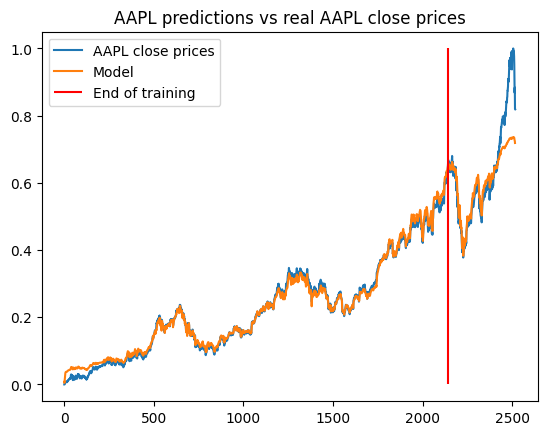

In [ ]:
close_idx = 3
train_outputs = []
labels = []
train_size = len(train_dataset)

model.eval()
for k, data in enumerate(train_dataset):
    # Put the data on the appropriate device
    data = data.to(device = device)
    labels.append(data[0, close_idx].item())
    if k == 0:
        inp = data
        hn = torch.zeros(model.num_layers, model.hidden_size, device=device)
        cn = torch.zeros(model.num_layers, model.hidden_size, device=device)
        continue
    
    # Counting size of dataset
    sequence_length, input_dim = data.shape

    # Getting the label of the model (close price)
    label = data[:, close_idx:close_idx + 1]
    
    # Computation of the output
    output, (hn, cn) = model(inp, (hn, cn))
    train_outputs.append(output.item())
    inp = data

for k, data in enumerate(test_dataset):
    # Put the data on the appropriate device
    data = data.to(device = device)
    labels.append(data[0, close_idx].item())
    
    # Counting size of dataset
    sequence_length, input_dim = data.shape

    # Getting the label of the model (close price)
    label = data[:, close_idx:close_idx + 1]
    
    # Computation of the output
    output, (hn, cn) = model(inp, (hn, cn))
    train_outputs.append(output.item())
    inp = data

plt.plot(labels, label = 'AAPL close prices')
plt.plot(train_outputs, label = 'Model')
plt.title('AAPL predictions vs real AAPL close prices')
plt.vlines(len(train_dataset), 0, 1, 'r', label = 'End of training')
plt.legend()
plt.show()

In [ ]:
for k, data in enumerate(train_dataset):
    if k == 1000:
        output, (hn, cn) = model(data, (hn, cn))
        print(output)
    if k == 1001:
        break

tensor([[0.2681]], grad_fn=<AddmmBackward0>)
